<a href="https://colab.research.google.com/github/gannygit/interval-analysis-and-transposition/blob/main/Interval_analysis_and_transposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scale interval analysis

Author: Bhushan Agarwal/ Gannygit

In this Colab notebook, we will analyse intervals in a given musical scale, apply interval-preserving transpositions, and visualise the results. Basic familiarity with python coding as well as elementary music will be beneficial to make the most of this material.

Just read through the text, run all code cells (changing key inputs as needed), and observe the output.

##Introduction
A musical scale contains a set of notes, usually between 5 and 7 notes, spanning an octave. These notes are separated by intervals. An interval is the difference in pitch between two sounds. The interval between any pair of notes can be described in terms of the semitones separating them. For example, the pair (komal re, sa) [or (ri1, sa)] has an interval of 1 semitone, or minor second, which is the same interval as the pair (shuddh ni, sa) [or (ni3, sa)].

For the purposes of this analysis, we will ignore microtones and treat an interval as quantised; thus an interval of 85 cents can be considered 1 semitone. This way, the exact tuning of a scale is irrelevant. Any pitch class or svarasthāna differs from its adjacent pitch classes by 1 semitone.

###Approach
For interval analysis, we only need a symbolic representation of the scale (or a melody); we don't need info about gamaka, fine-tuning (microtones), and musical context (such as ascent and descent).
1. Symbolic score. This depicts the sequence of notes coded as a list (array) of numbers. We will define 0 to represent the tonic note, and all notes above and below it will be represented by the integer number of semitones separating that note from the tonic. Therefore, pa  in the middle octave will be 7, and komal dha (or dha1) in the lower octave will be -4. For example, the sequence of notes in the ascending scale of bilāval/śankarābharaṇam is [0,2,4,5,7,9,11,12].

![chromatic](https://drive.google.com/uc?id=1IJV-6RnTV54TwHcYBeIWThiVjJ2PVSgG)


| Number | Karnatic | Hindustani |Code|
| :- | :- | :- ||
|Lower octave||||
|-12|sa|sa|sa
| -11 | ri1 | komal re |re1
| -10 | ri2/ga1 | shuddh re |re2
| -9 | ri3/ga2 | komal ga |ga1
| -8 | ga3 | shuddh ga |ga2
| -7 | ma1 | shuddh ma |ma1
| -6 | ma2 | tivra ma |ma2
| -5 | pa | pa |pa
| -4 | dha1 | komal dha |dha1
| -3 | dha2/ni1 | shuddh dha |dha2
| -2 | dha3/ni2 | komal ni |ni1
| -1 | ni3 | shuddh ni |ni2
|||||
|Middle octave||||
|0|sa|sa|Sa
| 1 | ri1 | komal re |Re1
| 2 | ri2/ga1 | shuddh re |Re2
| 3 | ri3/ga2 | komal ga |Ga1
| 4 | ga3 | shuddh ga |Ga2
| 5 | ma1 | shuddh ma |Ma1
| 6 | ma2 | tivra ma |Ma2
| 7 | pa | pa |Pa
| 8 | dha1 | komal dha |Dha1
| 9 | dha2/ni1 | shuddh dha |Dha2
| 10 | dha3/ni2 | komal ni |Ni1
| 11 | ni3 | shuddh ni |Ni2
|||||
|Upper octave||||
|12|sa|sa|SA
| 13 | ri1 | komal re |RE1
| 14 | ri2/ga1 | shuddh re |RE2
| 15| ri3/ga2 | komal ga |GA1
| 16 | ga3 | shuddh ga |GA2
| 17 | ma1 | shuddh ma |MA1
| 18 | ma2 | tivra ma |MA2
| 19 | pa | pa |PA
| 20 | dha1 | komal dha |DHA1
| 21 | dha2/ni1 | shuddh dha |DHA2
| 22 | dha3/ni2 | komal ni |NI1
| 23 | ni3 | shuddh ni |NI2




2. MIDI file. MIDI is short for Musical Instrument Digital Interface. Devices that make and control sound — such as synthesizers, samplers, controllers, and computers  — communicate with each other using MIDI messages. We will create a MIDI file here that can be played using a MIDI player/synthesiser.

In [1]:
pip install mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage

###Symbolic score
For our analysis, we need to specify the notes in the scale. We will have to analyse the ascent and descent separately.

In [3]:
# Examples of scales

ascent = np.asarray([0,4,5,7,9]) # change as required; only integer values between 0 and 11 in ascending order
descent = np.asarray([0,4,5,7,9,10]) # change as required; only integer values between 0 and 11 in ascending order
scale = np.asarray([0,1,4,5,7,8,11])

Alternatively, the scales can be represented using musical notation, like below:

In [49]:
scale = ['Sa',"Re1","Ga2","Ma1","Pa","Dha1","Ni2"]

We can then convert this to numerical notation using this dictionary:

In [50]:
note_levels = {
    "sa":-12, "re1":-11, "re2":-10, "ga1":-9, "ga2":-8, "ma1":-7,"ma2":-6,
    "pa":-5, "dha1":-4, "dha2":-3, "ni1":-2, "ni2":-1,
    "Sa": 0, "Re1":1, "Re2": 2, "Ga1":3, "Ga2": 4, "Ma1": 5, "Ma2":6,
    "Pa": 7, "Dha1":8, "Dha2": 9, "Ni1":10, "Ni2": 11,
    "SA": 12, "RE1":13, "RE2": 14, "GA1":15, "GA2": 16, "MA1":17, "MA2":18,
    "PA":19, "DHA1":20, "DHA2":21, "NI1":22, "NI2":23
}

In [51]:
scale = np.asarray(list(note_levels[note] for note in scale))
print(scale)

[ 0  1  4  5  7  8 11]


##Visualising a scale
We will visualise the scale as a one-hot encoded heatmap: 0 for notes that are not present, and 1 for notes that are present in the scale.


In [4]:
# one-hot encoding of one scale
def one_hot_linear(scale):
    one_hot_scale = np.asarray([])
    one = np.asarray([1])
    zero = np.asarray([0])
    for i in range(12):
        if i in scale:
            one_hot_scale = np.append(one_hot_scale,one)
        else:
            one_hot_scale = np.append(one_hot_scale,zero)
    return one_hot_scale.astype(int)

# one-hot encoding of a set of scales
def one_hot_matrix(interval_matrix):
    one_hot_2D = np.arange(12)
    for row in interval_matrix:
        one_hot_2D = np.vstack((one_hot_2D,one_hot_linear(row)))
    return one_hot_2D[1:][:]

We will now define a function to plot the one-hot encoded scales.

In [5]:
def heatmap(data, row_labels, col_labels, ax=None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    #if cbar_kw is None:
    #    cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), # rotation=-30,
             ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im #, cbar

Testing our functions:

In [6]:
x = np.array([[ 0,  4,  5,  7,  9], # sample data; set of scales. Each row is a scale
       [ 0,  1,  3,  5,  8],
       [ 0,  2,  4,  7,  11],
       [ 0,  2,  5,  9, 10],
       [ 0,  3,  7,  8, 10]])

In [7]:
y = one_hot_matrix(x)
y

array([[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]])

In [12]:
row_labels = np.arange(np.shape(y)[0])
col_labels = ['Sa','Re1','Re2','Ga1','Ga2','Ma1','Ma2','Pa','Dha1','Dha2','Ni1','Ni2']

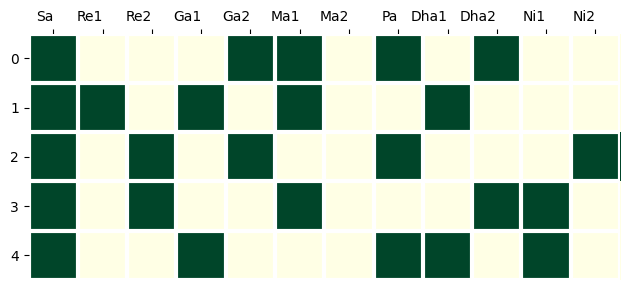

In [13]:
fig, ax = plt.subplots()

im = heatmap(y, row_labels, col_labels, ax=ax,
                   cmap="YlGn")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

Here, each row represents a scale. We will be dealing with sets of related scales, so this visualisation will be useful.

##Graphs
We can also depict each scale as a directed graph with vertices representing notes connected by arrows (edges). For this, we will first convert numerical notation to musical notation. This will help with labelling of the notes on the graph.

In [52]:
def numbers_to_notation(score):
    disp_score = []
    for row in score:
        phrase = []
        for value in row:
            phrase = np.append(phrase,get_key(value))
        #print(phrase)
        if len(disp_score) == 0:
            disp_score = [np.concatenate((disp_score,phrase))]
        else:
            disp_score = np.concatenate((disp_score,[phrase]))

    return disp_score


def get_key(val):

    for key, value in note_levels.items():
        if val == value:
            return key

    return float("nan")

We will also add the upper SA to the scale to make it 'complete'

In [68]:
def add_octave(matrix):
    new_matrix = np.concatenate((matrix[0],[12]))
    for row in matrix:
        y = np.concatenate((row,[12]))
        new_matrix = np.vstack((new_matrix,y))
    return new_matrix[1:]

In [69]:
scale = add_octave([scale])

In [70]:
score = numbers_to_notation(scale)
score[0]

array(['Sa', 'Re1', 'Ga2', 'Ma1', 'Pa', 'Dha1', 'Ni2', 'SA'], dtype='<U32')

In [78]:
np.shape(score)

(1, 8)

Now we construct and visualise a graph using our scale(s).

In [59]:
def construct_graph_from_phrases(phrases):
    G = nx.DiGraph()

    # Create Nodes and Edges for Each Phrase
    for phrase_index, phrase in enumerate(phrases):
        for note_index, note in enumerate(phrase):
            node_id = f"{note}_{phrase_index}_{note_index}"
            is_griha = (note_index == 0)
            is_nyasa = (note_index == len(phrase) - 1)

            G.add_node(node_id, note=note, is_griha=is_griha, is_nyasa=is_nyasa)

            if note_index > 0:
                prev_note = phrase[note_index - 1]
                prev_node_id = f"{prev_note}_{phrase_index}_{note_index-1}"
                G.add_edge(prev_node_id, node_id)


    return G

In [71]:
G = construct_graph_from_phrases(score)

In [72]:
def visualize_graph(graph, disp_score, note_levels):
    pos = {node: (i, note_levels[attrs["note"]]) for i, (node, attrs) in enumerate(graph.nodes(data=True))}

    plt.figure(figsize=(12,6))

    # Draw the full graph
    #nx.draw(graph, pos, with_labels=True, node_color='lightgrey', node_size=35, font_size=10, arrows=True)

    # Highlight griha and nyasa notes
    nyasa_nodes = [node for node, attrs in graph.nodes(data=True) if (attrs["is_nyasa"] and not attrs["is_griha"])]
    griha_nodes = [node for node, attrs in graph.nodes(data=True) if (attrs["is_griha"] and not attrs["is_nyasa"])]
    mix_nodes = [node for node, attrs in graph.nodes(data=True) if (attrs["is_griha"] and attrs["is_nyasa"])]
    other_nodes = [node for node in graph.nodes() if node not in griha_nodes and node not in nyasa_nodes and node not in mix_nodes]

    # grid lines/ reference lines for visualisation
    x = np.arange(len(graph.nodes))



    plotted = []
    for phrase in disp_score:
        for note in phrase:
            if note not in plotted:
                if note_levels[note] in [-5,0,7,12,19]:
                    plt.plot(x,(note_levels[note]+x*0),color='green')
                else:
                    plt.plot(x,(note_levels[note]+x*0),color='grey',linewidth=0.5)
                plotted = np.append(plotted,note)


    nx.draw_networkx_nodes(graph, pos, nodelist=griha_nodes, node_color='green', node_size=100, label='Griha Notes')
    nx.draw_networkx_nodes(graph, pos, nodelist=nyasa_nodes, node_color='red', node_size=100, label='Nyasa Notes')
    nx.draw_networkx_nodes(graph, pos, nodelist=mix_nodes, node_color='cyan', node_size=100, label='Mix Notes')
    nx.draw_networkx_nodes(graph, pos, nodelist=other_nodes, node_color='lightblue', node_size=100, label='Other Notes')

    # draw edges
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, arrowstyle='-|>', arrowsize=10)

    # Draw node labels with note names
    note_labels = {node: attrs["note"] for node, attrs in graph.nodes(data=True)}
    nx.draw_networkx_labels(graph, pos, labels=note_labels, font_size=10, font_color='black')


    # add a legend
    #plt.legend(scatterpoints=1, loc='upper left')

    # Show the plot
    #plt.title("Musical Phrase Graph")
    plt.title("Scales as a graph")
    plt.show()

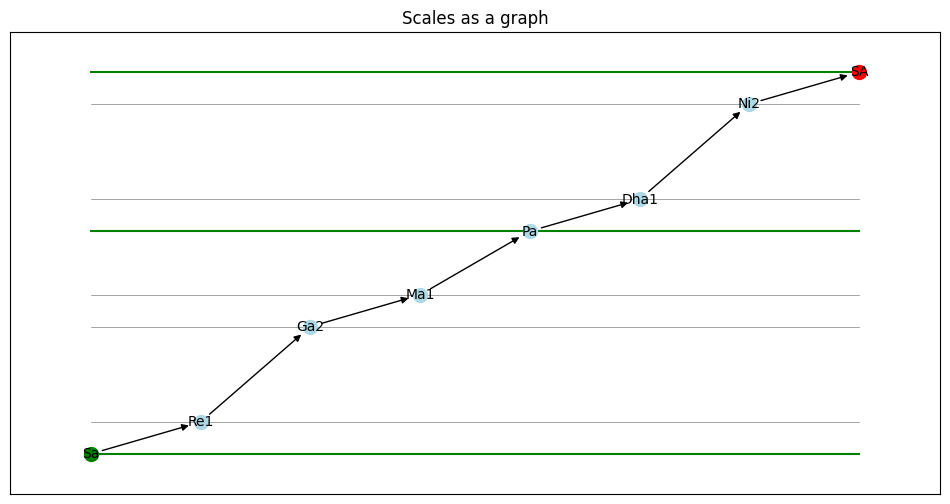

In [73]:
# visualize the graph
visualize_graph(G, score, note_levels)

###Colour-coded visualisation

Assigning different colours to each note can help us better visualise how the scales are related to each other.

In [14]:
def graded_linear(scale):
    graded_scale = np.asarray([])
    one = np.asarray([1])
    zero = np.asarray([-1])
    for i in range(12):
        if i in scale:
            graded_scale = np.append(graded_scale,one*i)
        else:
            graded_scale = np.append(graded_scale,zero)
    return graded_scale.astype(int)


def graded_matrix(interval_matrix):
    graded_2D = graded_linear(interval_matrix[0])
    x = graded_linear(interval_matrix[0])
    for i in x:
        if i >=0:
            y = np.concatenate((x[i:],x[:i]))
            graded_2D = np.vstack((graded_2D,y))
    return graded_2D[1:][:]

In [15]:
y = graded_matrix(x)
y

array([[ 0, -1, -1, -1,  4,  5, -1,  7, -1,  9, -1, -1],
       [ 4,  5, -1,  7, -1,  9, -1, -1,  0, -1, -1, -1],
       [ 5, -1,  7, -1,  9, -1, -1,  0, -1, -1, -1,  4],
       [ 7, -1,  9, -1, -1,  0, -1, -1, -1,  4,  5, -1],
       [ 9, -1, -1,  0, -1, -1, -1,  4,  5, -1,  7, -1]])

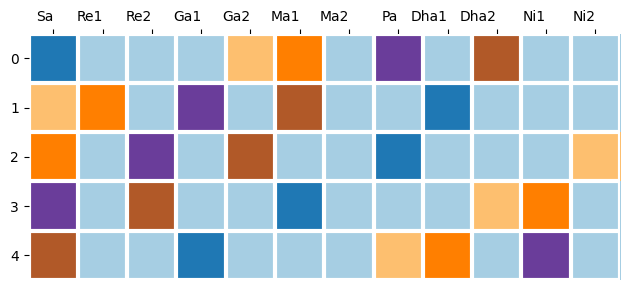

In [16]:
fig, ax = plt.subplots()

im = heatmap(y, row_labels, col_labels, ax=ax,
                   cmap="Paired")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

Here, we can see that each note in a scale corresponds to some other note in each of the other scales. For example, the tonic (sa, 0) in the top row (blue) becomes the minor third (komal ga/ ga2, 3) in the bottom row (blue). All the scales in this set are transpositions of each other.

##Calculating intervals

Now we will calculate the intervals between all pairs of notes in a given scale. This will give us the interval matrix.

In [43]:
def interval_matrix(scale):
    matrix = scale
    for item_1 in scale:
        row = np.asarray([])
        for item_2 in scale:
            difference = item_2 - item_1
            if difference < 0:
                difference += 12
            row = np.append(row,difference)
        matrix = np.vstack((matrix,row))
    return matrix[1:][:].astype(int)


In [44]:
x = interval_matrix(ascent)
print(x)

[[ 0  4  5  7  9]
 [ 8  0  1  3  5]
 [ 7 11  0  2  4]
 [ 5  9 10  0  2]
 [ 3  7  8 10  0]]


We can also display this matrix in musical notations instead of numbers.

In [46]:
print(numbers_to_notation(x))

[['Sa' 'Ga2' 'Ma1' 'Pa' 'Dha2']
 ['Dha1' 'Sa' 'Re1' 'Ga1' 'Ma1']
 ['Pa' 'Ni2' 'Sa' 'Re2' 'Ga2']
 ['Ma1' 'Dha2' 'Ni1' 'Sa' 'Re2']
 ['Ga1' 'Pa' 'Dha1' 'Ni1' 'Sa']]


##Interpreting the interval matrix
The interval matrices indicate the distance between all pairs of notes in semitones. This distance is directional. We must look horizontally for ascent and vertically for descent. For example, if we have a scale [0,4,5,7,9,10] (sa, shuddh ga/ ga3, shuddh ma/ ma1, pa, shuddh dha/ dha2, komal ni/ ni3) (depicted below),
![scale](https://drive.google.com/uc?id=1Np-WgYQX55kr0KSYRl_LB4ocza_md7n9)


we get the following interval matrix:

![matrix](https://drive.google.com/uc?id=1XBFtuic7JRjKmxuhQxGCFRhWiYo6yLLf)












To see how far above a note is from another, locate the zero of first note and see the number curresponding to the second note's column. For example, if we want to see how far ma (5) is from ga (4), we locate the zero of 4 and read the number in the column titled '5'.

![ascent](https://drive.google.com/uc?id=1XUpJicCvmZw8GQSyCWy-1eC7M8JPW6fQ)











To see how far below a note is from another, locate the zero of the first note and see the number corresponding to the second note's row. For example, if we want to see how far ma (5) is from pa (7), we locate the zero of 7 and read the number in the row titled '5'.

![descent](https://drive.google.com/uc?id=1a1JlIg94OtkxLEzSm7cxU6i38x9xbdPU)


##Transposition/ gṛhabheda

For this, we choose any note from the given scale as the new tonic, and interpret all the other notes (the same notes as in the original scale) relative to this new tonic. For example, starting with the same scale as in the above example, if we choose ma as our new tonic, then the original ga becomes ni.

We can approach transposition in two ways. One is to arrive at a different scale. A reinterpretation of all the notes of a given scale with respect to a new tonic yields a new scale. The other way is to stay in the same scale but hint at other scales by drawing parallels in the intervals.

###Tranposing the tonic

To transpose the tonic of a given scale, read along the row number to which you want to transpose. For example, for the same scale as in the above example [0,4,5,7,9,10], if we want to transpose the tonic to ma (5), just read the scale along that row, and the transposed scale would be [0,2,4,5,7,11].






![ascent](https://drive.google.com/uc?id=1D5dLwcWGyCsGS_zgG2X2y4PNP0uxQCIg)


We must manually check whether this new scale is practically feasible and whether it conforms to theoretical constraints. We can then use this new scale as it is or to inspire phrases in our original scale.

To view all rows as scales starting from zeroes, we need to align all the zeroes and add the upper sa (an octave above the tonic):

In [19]:
def align_tonic(matrix):
    aligned = matrix[0]
    for row in matrix:
        i = int(np.where(row==0)[0])
        y = np.concatenate((row[i:],row[:i]))
        aligned = np.vstack((aligned,y))
    return aligned[1:]

'''
# already define earlier
def add_octave(matrix):
    new_matrix = np.concatenate((matrix[0],[12]))
    for row in matrix:
        y = np.concatenate((row,[12]))
        new_matrix = np.vstack((new_matrix,y))
    return new_matrix[1:]
'''

In [77]:
a = align_tonic(x)
a = add_octave(a)
a

<ipython-input-19-324e1ba8db91>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])


array([[ 0,  4,  5,  7,  9, 12],
       [ 0,  1,  3,  5,  8, 12],
       [ 0,  2,  4,  7, 11, 12],
       [ 0,  2,  5,  9, 10, 12],
       [ 0,  3,  7,  8, 10, 12]])

In [80]:
a = numbers_to_notation(a)

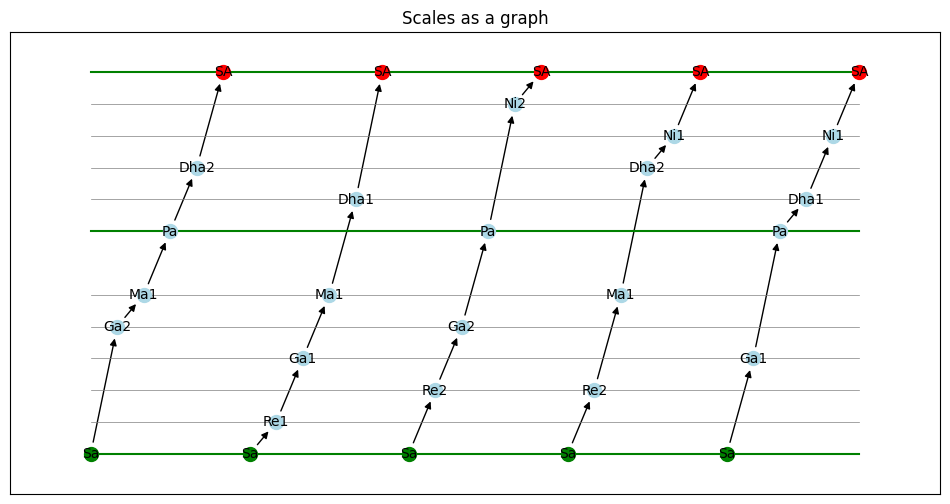

In [81]:
G = construct_graph_from_phrases(a)
visualize_graph(G, a, note_levels)

##Hearing the scales in MIDI
We can generate MIDI files to hear the scales. For this, we need to specify a scale and the fine tuning.

In [21]:
scale_1 = [0,2,4,5,7,11]
chromatic_ascent = [0,1,2,3,4,5,6,7,8,9,10,11] # set of all permissible notes in a scale; only middle octave
c_n = [0,0,0,0,0,0,0,0,0,0,0,0] # fine tuning in cents

We also need a function to extract the position of a given pitch class relative to A. We are using a function here that returns this position as well as the actual frequency of the note, but we don't need the value of frequency for this analysis.

In [22]:
def note_to_freq(note):
    if len(note) < 2 or len(note) > 3 or note[0] < 'A' or note[0] > 'G':
        return 0
    if len(note) == 3:
        if note[1] == 'b':
            acc = -1
        elif note[1] == '#':
            acc = 1
        else:
            return 0
        octave = int(note[2])
    else:
        acc = 0
        octave = int(note[1])
    SEMITONES = {'A': 0, 'B': 2, 'C': -9, 'D': -7, 'E': -5, 'F': -4, 'G': -2}
    n = 12 * (octave - 4) + SEMITONES[note[0]] + acc
    f = 440 * (2 ** (float(n) / 12.0))
    #print note, f
    return f,n

We also need a function to convert a score from our convention (where sa = 0) to MIDI note numbers.

In [23]:
def score_to_MIDI_score(score,tonic_note):
    MIDI_score = np.asarray([])
    tonic_f,n = note_to_freq(tonic_note)
    n = n+57 +12
    for note in score:
        MIDI_score = np.append(MIDI_score,note+n).astype(int)
    return(MIDI_score)

We will use the following function to create a MIDI file for a given score.

In [24]:
def create_midi_file(MIDI_score, ascent, c_n, tonic_note, bpm = 80):

    temp=int(1000000*60/bpm)
    octave = MIDI_score[0] + 12

    # Create a MIDI file and a track
    midi_file = MidiFile()
    track = MidiTrack()
    midi_file.tracks.append(track)

    # Set the instrument (program) for the track (optional)
    track.append(Message('program_change', program=0, time=0))

    # Set the tempo
    track.append(MetaMessage('set_tempo', tempo=temp, time=0))

    bend_value = 0
    # Add note-on and note-off messages for each note
    for note_pitch in MIDI_score:
        if note_pitch == octave:
            time = 480
        else:
            time = 0

        # Note On message
        track.append(Message('note_on', note=note_pitch, velocity=100, time=0))

        # Fine-tuning the pitch
        index = MIDI_note_to_index(note_pitch, ascent, tonic_note)
        if(c_n[index] != 0 or bend_value != 0):
            bend_value = int(c_n[index]*8191/200) # works only for pitch bend range of +/- 2 semitones
            track.append(Message('pitchwheel', pitch=bend_value, time=0))

        # Note Off message (assuming a duration of 1 beat for each note, except for the upper sa, which lasts 2 beats)
        track.append(Message('note_off', note=note_pitch, velocity=100, time=480+time))  # 480 ticks = 1 beat

    # Save the MIDI file
    return(midi_file)

def MIDI_note_to_index(note,ascent,tonic_note):
    MIDI_ascent = score_to_MIDI_score(ascent,tonic_note)
    index = int(np.where(MIDI_ascent%12 == note%12)[0])
    return index

Let's define an analysis function so we can just call that function to analyse various scales.

In [82]:

def interval_analysis(scale,chromatic_ascent,c_n, filename, tonic_note='C3',bpm=160, reg_colour = False, note_levels = note_levels):
    x = interval_matrix(scale) # calculating the interval matrix
    aligned_matrix = align_tonic(x) # aligning the tonics
    aligned_matrix = add_octave(aligned_matrix) # adding the upper sa to each scale

    # creating and saving a MIDI file
    score = aligned_matrix.flatten()
    MIDI_score = score_to_MIDI_score(score, tonic_note)
    midi_file = create_midi_file(MIDI_score, chromatic_ascent, c_n, tonic_note,bpm)
    midi_file.save(filename)
    print("MIDI file saved as "+filename+'.mid')

    # visualising the interval matrix
    if reg_colour == False:
        y = graded_matrix(x)
        palette = 'Paired'
    else:
        y = one_hot_matrix(x)
        palette = 'YlGn'

    fig, ax = plt.subplots()
    row_labels = np.arange(np.shape(y)[0])
    col_labels = ['0','1','2','3','4','5','6','7','8','9','10','11']
    im = heatmap(y, row_labels, col_labels, ax=ax,
                    cmap=palette)

    # visualising the scales as graphs
    score = numbers_to_notation(aligned_matrix)
    G = construct_graph_from_phrases(score)
    visualize_graph(G, score, note_levels)

    fig.tight_layout()
    plt.show()

##Examples

We will initialise the tonic to C3 and tempo to 160 bpm for all examples. We will also define the fine-tuning parameters.

In [83]:
tonic_note = 'C3' # specifying the tonic note
bpm = 160 # tempo in beats per minute

chromatic_ascent = [0,1,2,3,4,5,6,7,8,9,10,11] # set of all permissible notes in a scale; only middle octave
c_n = [0,0,0,0,0,0,0,0,0,0,0,0] # fine tuning in cents

###Example 1

In [84]:
scale_1 = [0,2,4,5,7,11]

<ipython-input-19-324e1ba8db91>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])
<ipython-input-24-b4ea1f412213>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.where(MIDI_ascent%12 == note%12)[0])


MIDI file saved as scale_1.mid


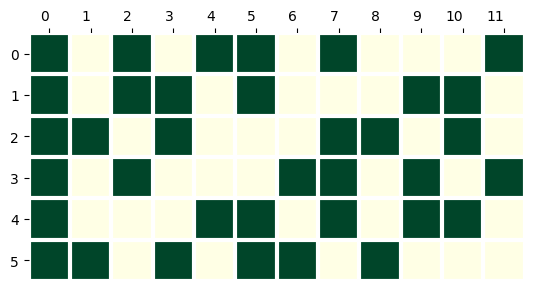

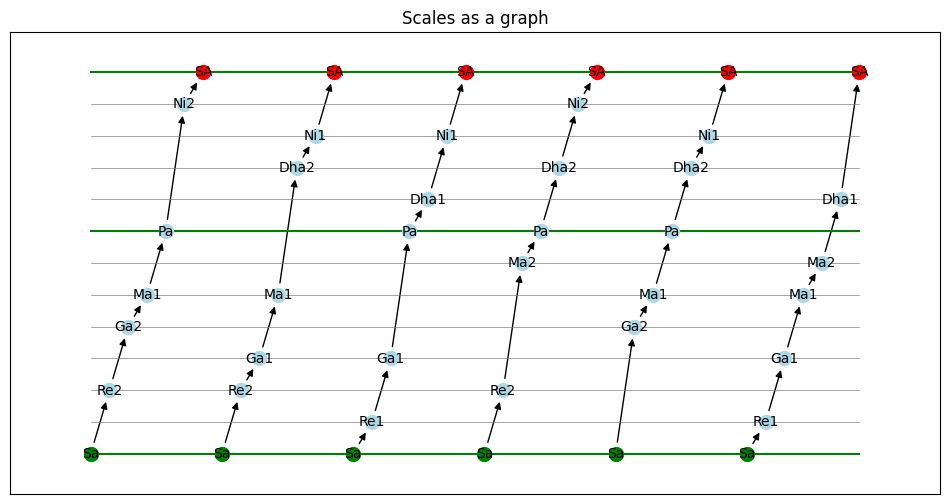

In [85]:
interval_analysis(scale_1,chromatic_ascent,c_n, filename='scale_1', tonic_note='C3',bpm=160, reg_colour = True)

###Example 2

In [86]:
scale_2 = [0,2,4,7,11]

<ipython-input-19-324e1ba8db91>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])
<ipython-input-24-b4ea1f412213>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.where(MIDI_ascent%12 == note%12)[0])


MIDI file saved as scale_2.mid


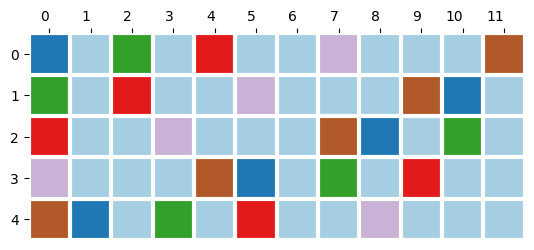

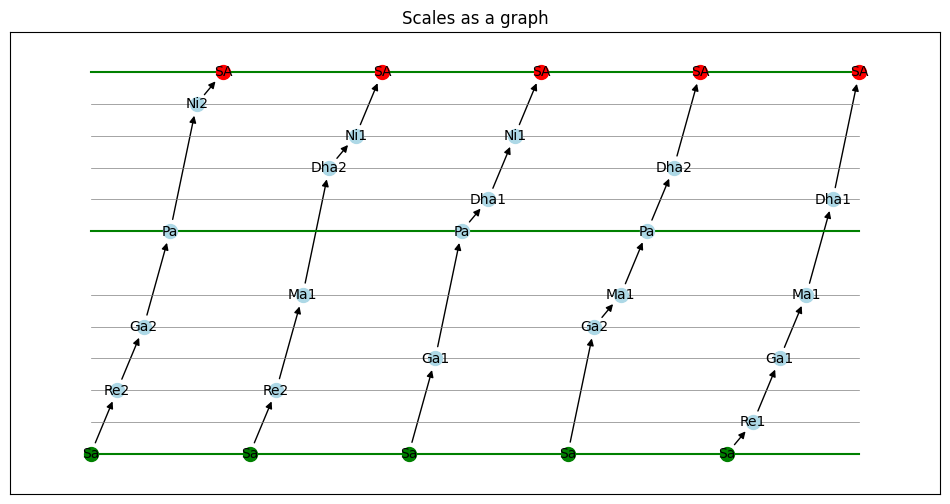

In [87]:
interval_analysis(scale_2,chromatic_ascent,c_n, filename='scale_2', tonic_note='C3',bpm=160, reg_colour = False)

###Example 3
Enter your own example scale and parameters below.

In [88]:
scale_3 = [0,4,7] # specify the notes in your scale; only integers between 0 and 11, in ascending order
filename = "scale_3" # specify the file name you want to save the MIDI file with
tonic_note = "C3"
colour = False # set to True for regular visualisation, and False for colour-coded visualisation
c_n = [0,0,0,0,0,0,0,0,0,0,0,0] # fine tuning in cents; change if required

<ipython-input-19-324e1ba8db91>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(np.where(row==0)[0])
<ipython-input-24-b4ea1f412213>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.where(MIDI_ascent%12 == note%12)[0])


MIDI file saved as scale_3.mid


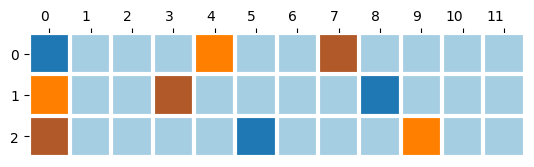

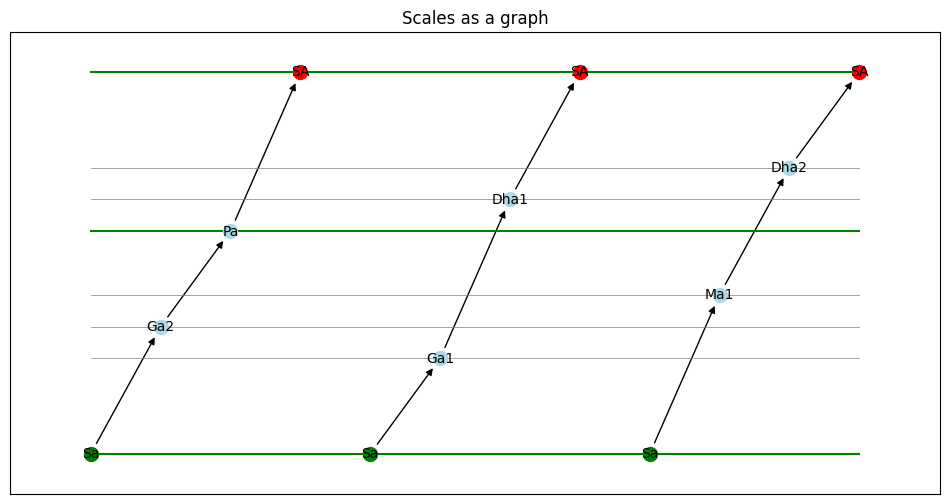

In [89]:
interval_analysis(scale_3,chromatic_ascent,c_n, filename, tonic_note,bpm=160, reg_colour = colour)